In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

from scipy import signal
import numpy as np
from scipy.ndimage import zoom


import torch.optim as optim

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import gc

In [4]:
case_list = ['endo slow', 'endo fast']# , 'exo slow', 'exo fast']
tmax_list = [3.75, 3.25, 2.882, 2.382]
# tmax_list = [0.2, 0.2, 0.2, 0.2]
fs = 1200
# eeg = np.empty((0, 32, int(tmax_list[3]*fs)+1)) # for endo exo together
eeg = np.empty((0, 32, 3900))
rt = np.empty((0,))
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    # watch = '11 stim'
    tmin = 0 # include fix or not?

    highpass = 4 # 0.3
    lowpass = 50

    EP_lists, RT_lists = fe.pipeline_EP_RT(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), move_baseline=False)
    eeg_tmp = np.vstack(EP_lists)
    
    if case =="endo slow":
        eeg_tmp = np.concatenate((eeg_tmp[:,:,:int(3*fs)], eeg_tmp[:,:,int(3.5*fs):]), axis=2)

#     # make eeg to same length
#     if case=="endo slow":
#             eeg_tmp = np.concatenate((eeg_tmp[:,:,:int((1.5+0.033*4)*fs)], eeg_tmp[:,:,int(2.5*fs):3*fs], eeg_tmp[:,:,int(3.5*fs):]), axis=2)
#     elif case=="endo fast":
#             eeg_tmp = np.concatenate((eeg_tmp[:,:,:int((1.5+0.033*4)*fs)], eeg_tmp[:,:,int(2.5*fs):]), axis=2)
#     elif case=="exo slow":
#             eeg_tmp = np.concatenate((eeg_tmp[:,:,:int((1.5+0.033*4+0.5)*fs)], eeg_tmp[:,:,int((1.5+0.033*4+1)*fs):]), axis=2)
        

    rt_tmp = np.hstack(RT_lists)

    eeg = np.vstack((eeg, eeg_tmp))
    rt = np.hstack((rt, rt_tmp))


SyntaxError: invalid syntax (1329859641.py, line 7)

In [ ]:
channel = 24
eeg_onechan = eeg[:,channel-1,:] * 1e6
cwtm_onechan = np.empty((eeg_onechan.shape[0], 200, 200))
t = np.linspace(0, eeg.shape[2]/fs, eeg.shape[2])

# Logarithmic frequency values
fmin = 4  # Minimum frequency
fmax = 50   # Maximum frequency
num_freqs = 200
freq = np.logspace(np.log10(fmin), np.log10(fmax), num_freqs)
cycles = 5 # hyperparameter!!!
widths = cycles*fs / (2*freq*np.pi)

for i in range(eeg_onechan.shape[0]):
    # print(i)
    one_trial = eeg_onechan[i,:]
    cwtm = signal.cwt(one_trial, signal.morlet2, widths, w=cycles).__abs__()
    cwtm_resized = zoom(cwtm, (1, 200/cwtm.shape[1]))
    cwtm_onechan[i,:,:] = cwtm_resized

In [ ]:
# Convert your data to PyTorch tensors
cwtm_tensor = torch.FloatTensor(cwtm_onechan)
rt_tensor = torch.FloatTensor(rt)

# Split the data into training and testing sets
X_train, X_tmp, y_train, y_tmp = train_test_split(cwtm_tensor, rt_tensor, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

train_dataset = TensorDataset(X_train.unsqueeze(1), y_train)  # Add channel dimension
test_dataset = TensorDataset(X_test.unsqueeze(1), y_test)     # Add channel dimension
valid_dataset = TensorDataset(X_valid.unsqueeze(1), y_valid) # Add channel dimension

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3), # 3,64=> 1,64
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, 1) # originally (512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten
        x = self.fc(x)

        return x.squeeze() # originally return x

In [ ]:
num_classes = 1 # regression, originally=10
num_epochs = 20
batch_size = 16
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

In [ ]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
        train_loss = loss.item()
            
    # Validation
    valid_loss = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            del images, labels, outputs

    valid_loss /= len(valid_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

Epoch [1/20], Train Loss: 0.2501, Valid Loss: 0.1091
Epoch [2/20], Train Loss: 0.2271, Valid Loss: 0.2340
Epoch [3/20], Train Loss: 0.1069, Valid Loss: 0.1378
Epoch [4/20], Train Loss: 0.1066, Valid Loss: 0.0825
Epoch [5/20], Train Loss: 0.1071, Valid Loss: 0.0931
Epoch [6/20], Train Loss: 0.0685, Valid Loss: 0.0888
Epoch [7/20], Train Loss: 0.0500, Valid Loss: 0.0776
Epoch [8/20], Train Loss: 0.0641, Valid Loss: 0.0897
Epoch [9/20], Train Loss: 0.0712, Valid Loss: 0.0663
Epoch [10/20], Train Loss: 0.0708, Valid Loss: 0.0762
Epoch [11/20], Train Loss: 0.0632, Valid Loss: 0.0691
Epoch [12/20], Train Loss: 0.0616, Valid Loss: 0.0798
Epoch [13/20], Train Loss: 0.0747, Valid Loss: 0.0755
Epoch [14/20], Train Loss: 0.0730, Valid Loss: 0.0683
Epoch [15/20], Train Loss: 0.0558, Valid Loss: 0.0744
Epoch [16/20], Train Loss: 0.0874, Valid Loss: 0.0944
Epoch [17/20], Train Loss: 0.0560, Valid Loss: 0.0685
Epoch [18/20], Train Loss: 0.0464, Valid Loss: 0.0654
Epoch [19/20], Train Loss: 0.0619, Va

In [ ]:
total_loss = 0
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        del images, labels, outputs

avg_loss = total_loss / len(test_loader)
print(f"Test Loss: {avg_loss:.4f}")
torch.cuda.empty_cache()

Test Loss: 0.0692


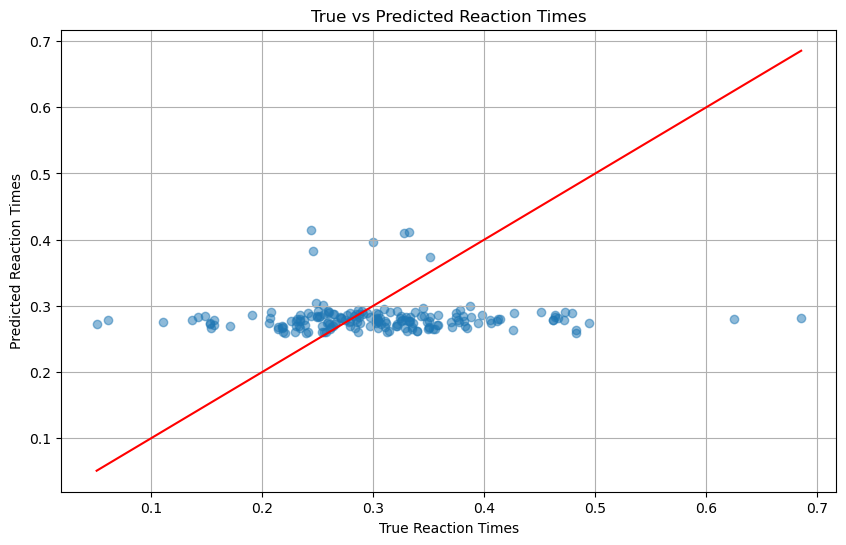

In [ ]:
all_targets = []
all_predictions = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        
        all_targets.extend(target.cpu().numpy())
        all_predictions.extend(outputs.cpu().numpy())

plt.figure(figsize=(10, 6))
plt.scatter(all_targets, all_predictions, alpha=0.5)
plt.plot([min(all_targets), max(all_targets)], 
         [min(all_targets), max(all_targets)], 
         color='red')
plt.xlabel('True Reaction Times')
plt.ylabel('Predicted Reaction Times')
plt.title('True vs Predicted Reaction Times')
plt.grid(True)
plt.show()